# Build and Validate a Model

In [1]:
import pandas as pd
import numpy as np

# Allows charts to appear in the notebook
%matplotlib inline

In [2]:
# data source: UCI
# https://archive.ics.uci.edu/ml/datasets.php
data = pd.read_csv("heart_disease/heart.csv")

## Check Data

In [3]:
data.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [4]:
data.shape

(303, 14)

In [7]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [9]:
data['target'].value_counts() 

1    165
0    138
Name: target, dtype: int64

<AxesSubplot: >

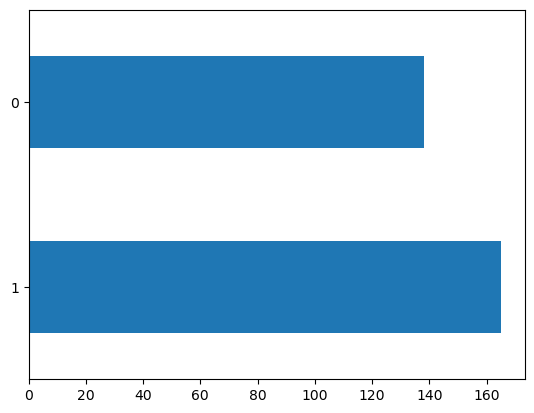

In [10]:
data.target.value_counts().plot(kind = 'barh')

In [11]:
#Get Target data 
y = data['target']

#Load X Variables into a Pandas Dataframe with columns 
X = data.drop(['target'], axis = 1)

In [12]:
print(f'X : {X.shape}')
print(f'y : {y.shape}')

X : (303, 13)
y : (303,)


In [13]:
X

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3


In [14]:
y

0      1
1      1
2      1
3      1
4      1
      ..
298    0
299    0
300    0
301    0
302    0
Name: target, Length: 303, dtype: int64

## Divide Data into Train and test

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [16]:
print(f'X_train : {X_train.shape}')
print(f'y_train : {y_train.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_test : {y_test.shape}')

X_train : (242, 13)
y_train : (242,)
X_test : (61, 13)
y_test : (61,)


## Build Basic Random Forest Model

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf_Model = RandomForestClassifier().fit(X_train, y_train)

- In random forests, each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set.

- Furthermore, when splitting each node during the construction of a tree, the best split is found either from all input features or a random subset of size max_features.

- The purpose of these two sources of randomness is to **decrease the variance of the forest estimator**. (High-dimensional data!)

- Indeed, individual decision trees typically exhibit high variance and tend to overfit. The injected randomness in forests yield decision trees with somewhat decoupled prediction errors. By taking an average of those predictions, some errors can cancel out. 

- Random forests achieve a reduced variance by combining diverse trees, sometimes at the cost of a slight increase in bias. In practice the variance reduction is often significant hence yielding an overall better model.

## Prediction

In [18]:
# Create a function to guess when an observation has heart disease 
def heartdisease(age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal):
    if(rf_Model.predict([[age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal]]))==1:
        print('You have heart disease!')
    else:
        print('You\'re fine!')

In [19]:
heartdisease(63,1,3,145,233,1,0,150,0,2.3,0,0,1)

You have heart disease!


/Users/percychan/opt/anaconda3/envs/CSS2023/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [20]:
heartdisease(56,0,1,130,236,0,0,174,0,0.0,1,1,2)

You have heart disease!


/Users/percychan/opt/anaconda3/envs/CSS2023/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [21]:
heartdisease(58,0,1,130,236,0,0,174,0,0.0,1,1,2)

You have heart disease!


/Users/percychan/opt/anaconda3/envs/CSS2023/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


## Check Accuracy

In [22]:
print ('Train Accuracy - : {:.3f}'.format(rf_Model.score(X_train,y_train)))
print ('Test Accuracy - : {:.3f}'.format(rf_Model.score(X_test,y_test)))

Train Accuracy - : 1.000
Test Accuracy - : 0.852


In [23]:
rf_Model.score(X_test,y_test)

0.8524590163934426

## Cross Validation

<img src="./img/cross_val.png" width="600"/>

In [25]:
from sklearn.model_selection import cross_validate

val_res = cross_validate(RandomForestClassifier(), X, y, cv=5, return_train_score=True)

In [26]:
pd.DataFrame(val_res)

,fit_time,score_time,test_score,train_score
0,0.119044,0.007019,0.836066,1.0
1,0.106611,0.006619,0.885246,1.0
2,0.105819,0.006603,0.819672,1.0
3,0.105699,0.006577,0.816667,1.0
4,0.106248,0.006693,0.750000,1.0


In [27]:
val_res['test_score'].mean()

0.8215300546448088

Note cross validation doesn't give us a 'better' model. The purpose is to assess how well a given model generalizes. 

## Parameter Tuning & Model Selection 

In [29]:
# A simple manual example

best_score = 0

for n in [20, 50, 100, 300]:
    rf_model = RandomForestClassifier(n_estimators = n).fit(X_train, y_train)
    score = rf_model.score(X_test, y_test)
    if score > best_score:
        best_score = score
        best_parameters = {'n_estimators': n}

print("Best score: {:.4f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Best score: 0.8689
Best parameters: {'n_estimators': 300}


In [31]:
[int(x) for x in np.linspace(start = 20, stop = 300, num = 10)]

[20, 51, 82, 113, 144, 175, 206, 237, 268, 300]

In [33]:
# Create the param grid

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 300, num = 10)]
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2,5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,3,4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
param_grid

{'n_estimators': [20, 51, 82, 113, 144, 175, 206, 237, 268, 300],
 'max_depth': [2, 4],
 'min_samples_split': [2, 5],
 'min_samples_leaf': [1, 2, 3, 4],
 'bootstrap': [True, False]}


- **GridSearch**
    - Exhaustive search over specified parameter values for an estimator.
    - GridSearchCV implements a “fit” and a “score” method. It also implements “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.
    - The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.
    - details: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

- cv is cross-validation, 
    - here I use 3 fold cross validation 
    - for more info, please see: https://machinelearningmastery.com/k-fold-cross-validation/

- n_jobs = int, default=None
    - Number of jobs to run in parallel. 
    - None means 1 unless in a joblib.parallel_backend context. 
    - -1 means using all processors.

- verboseinteger
    - Controls the verbosity: the higher, the more messages.

In [34]:
from sklearn.model_selection import GridSearchCV

rf_Grid = GridSearchCV(estimator = RandomForestClassifier(), 
                       param_grid = param_grid, cv = 3, verbose=2, n_jobs = 6)

In [35]:
rf_Grid.fit(X_train, y_train)

Fitting 3 folds for each of 320 candidates, totalling 960 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=6,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 5],
                         'n_estimators': [20, 51, 82, 113, 144, 175, 206, 237,
                                          268, 300]},
             verbose=2)

In [37]:
rf_Grid.best_params_

{'bootstrap': False,
 'max_depth': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 300}

## Check Accuracy Again

In [38]:
print ('Train Accuracy - : {:.4f}'.format(rf_Grid.score(X_train,y_train)))
print ('Test Accuracy - : {:.4f}'.format(rf_Grid.score(X_test,y_test)))


Train Accuracy - : 0.9091
Test Accuracy - : 0.8852


# Alternative Evaluation Metrics

In [39]:
rf_Model.score(X_test,y_test)

0.8524590163934426

In [40]:
# Confusion matrix 

from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, rf_Model.predict(X_test))

In [41]:
confusion

array([[22,  5],
       [ 4, 30]])

Note the orientation of the confusion matrix here is different from the one we see in class: 

<img src="./img/confusion_matrix.png" width="400"/>

In [42]:
# accuracy score 
(23 + 31) / (23 + 4 + 3 + 31)

0.8852459016393442

In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_test, rf_Model.predict(X_test), target_names=["no disease", "disease"]))

              precision    recall  f1-score   support

  no disease       0.85      0.81      0.83        27
     disease       0.86      0.88      0.87        34

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61

[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=51; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=113; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=175; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=237; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=14

[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=82; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=144; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=206; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=268; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=51; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=82; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=5

[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=51; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=113; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=175; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=237; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=113; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=175; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=237; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_spl

## Precision-Recall Curve

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, rf_Model.predict_proba(X_test)[:, 1])

Note `precision_recall_curve` requires the second argument to be a certainty measure of the positive class (class = 1)

In [45]:
rf_Model.predict_proba(X_test)

array([[0.87, 0.13],
       [0.41, 0.59],
       [0.27, 0.73],
       [1.  , 0.  ],
       [0.82, 0.18],
       [0.38, 0.62],
       [0.81, 0.19],
       [0.87, 0.13],
       [0.97, 0.03],
       [0.9 , 0.1 ],
       [0.44, 0.56],
       [0.07, 0.93],
       [0.94, 0.06],
       [0.02, 0.98],
       [0.05, 0.95],
       [0.37, 0.63],
       [0.79, 0.21],
       [0.2 , 0.8 ],
       [0.94, 0.06],
       [0.47, 0.53],
       [0.13, 0.87],
       [0.74, 0.26],
       [0.82, 0.18],
       [0.71, 0.29],
       [0.31, 0.69],
       [0.56, 0.44],
       [0.76, 0.24],
       [0.54, 0.46],
       [0.09, 0.91],
       [0.32, 0.68],
       [0.4 , 0.6 ],
       [0.91, 0.09],
       [0.02, 0.98],
       [0.23, 0.77],
       [0.02, 0.98],
       [0.61, 0.39],
       [0.82, 0.18],
       [0.05, 0.95],
       [0.92, 0.08],
       [0.73, 0.27],
       [0.33, 0.67],
       [0.53, 0.47],
       [0.17, 0.83],
       [0.85, 0.15],
       [0.59, 0.41],
       [0.35, 0.65],
       [0.18, 0.82],
       [0.49,

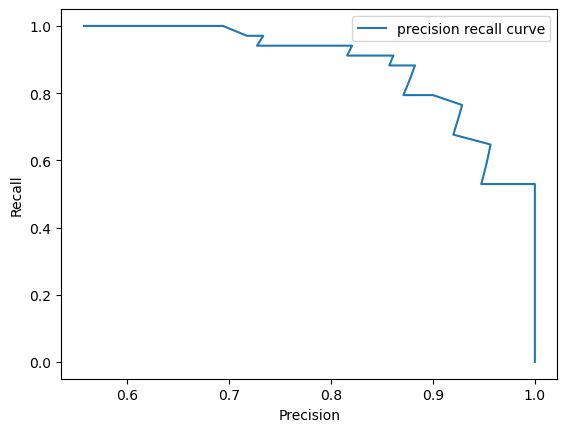

In [46]:
plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

## ROC Curve

In [47]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, rf_Model.predict_proba(X_test)[:, 1])

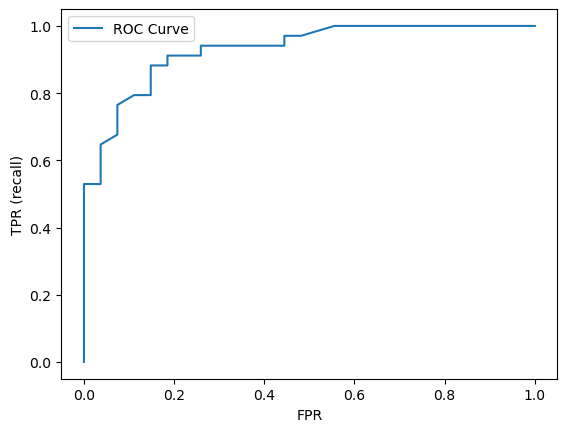

In [48]:
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.legend(loc="best")

## Compare two models 

In [49]:
from sklearn.svm import SVC

svm_Model = SVC().fit(X_train, y_train)

In [50]:
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, svm_Model.decision_function(X_test))

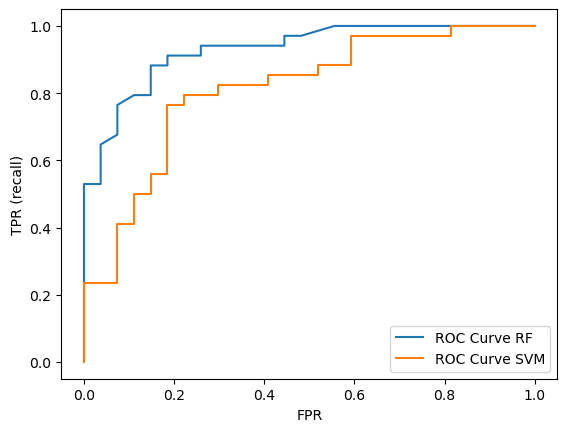

In [51]:
plt.plot(fpr, tpr, label="ROC Curve RF")
plt.plot(fpr_svm, tpr_svm, label="ROC Curve SVM")

plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.legend(loc="best")

## AUC Score

In [52]:
from sklearn.metrics import roc_auc_score

rf_auc = roc_auc_score(y_test, rf_Model.predict_proba(X_test)[:, 1])
svc_auc = roc_auc_score(y_test, svm_Model.decision_function(X_test))

print("AUC for Random Forest: {:.3f}".format(rf_auc))
print("AUC for SVC: {:.3f}".format(svc_auc))

AUC for Random Forest: 0.930
AUC for SVC: 0.812


In [53]:
rf_Grid_2 = GridSearchCV(estimator = RandomForestClassifier(), 
                       param_grid = param_grid, cv = 3, verbose=2, n_jobs = 6, 
                       scoring = 'roc_auc')

In [54]:
rf_Grid_2.fit(X_train, y_train)

Fitting 3 folds for each of 320 candidates, totalling 960 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=6,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 5],
                         'n_estimators': [20, 51, 82, 113, 144, 175, 206, 237,
                                          268, 300]},
             scoring='roc_auc', verbose=2)

In [55]:
rf_Grid_2.best_params_

{'bootstrap': True,
 'max_depth': 2,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 113}

In [56]:
rf_Grid.best_params_

{'bootstrap': False,
 'max_depth': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 300}

[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=82; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=144; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=206; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=268; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=51; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=82; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=5

[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=51; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=113; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=175; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=237; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=144; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=206; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=268; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=2, min_samples_spl

[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=82; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=144; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=206; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=268; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=51; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=82; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=5

# Resources in R

- Algorithms: [rpart](https://cran.r-project.org/web/packages/rpart/) for trees, [randomForest](https://cran.r-project.org/web/packages/randomForest/) for RF, [e1071](https://cran.r-project.org/web/packages/e1071/index.html) or [LiblineaR](https://cran.r-project.org/web/packages/LiblineaR/index.html) for SVM
- Model Building: 
    - see [PRROC](https://cran.r-project.org/web/packages/PRROC/vignettes/PRROC.pdf), [ROCR](https://cran.r-project.org/web/packages/ROCR/index.html), or [cutpointr](https://cran.r-project.org/web/packages/cutpointr/vignettes/cutpointr.html) for scoring tools
    - see [mlr3](https://mlr3book.mlr-org.com/basics.html#learners) for an integrated interface